Postavljanje okruženja

In [1]:
import pandas as pd
!pip install pandas openpyxl
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.svm import SVR
from matplotlib.dates import DateFormatter, AutoDateLocator
import matplotlib.dates as mdates
from itertools import combinations
from sklearn.model_selection import train_test_split
from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/My Drive/Diplomski/diplomski/datasets/amazon/Amazon_avg_sentiment.csv'

Mounted at /content/drive


Postavljanje dataseta:

* Dataset sadržava vrijednosti za svaki radni dan burze od 2015 do 2020
* Svaki redak sadržava datum i cijenu dionice na taj datum
* Svaki redak također sadržava cijenu dionice i ostale vrijednosti od prošlog radnog dana

In [2]:
data = pd.read_csv(file_path)

features_to_shift = [
  "Adj_Close","avg_score","std_score"
]

data['today_price'] = data['Adj_Close']
data[features_to_shift] = data[features_to_shift].shift(1)

data['prediction'] = data['today_price'] -  data['Adj_Close']

data['price_diff'] = data['prediction'].shift(1)

features_to_keep = [
  "Date","Adj_Close","avg_score","std_score", "prediction", 'price_diff', 'today_price'
]


data = data[features_to_keep]
data.dropna(inplace=True)

Parametri koji će se koristiti kao input (X) varijabla za model:
* Lako možemo promijeniti ulazne varijable

In [3]:
indicators_to_keep = [
"avg_score","std_score", 'price_diff'
]

In [4]:
train_size = int(len(data) * 0.8)

Tražimo najbolje parametre za model


In [5]:
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.1, 0.01, 0.001],
    'kernel': ['rbf', 'linear']
}

tscv = TimeSeriesSplit(n_splits=5)

best_params = None
best_error = float('inf')

X_train = data[indicators_to_keep]
y_train = data["prediction"]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

for params in GridSearchCV(SVR(), param_grid, cv=tscv, scoring='neg_mean_squared_error').fit(X_train_scaled, y_train).cv_results_['params']:
    errors = []
    for train_index, val_index in tscv.split(X_train_scaled):
        X_train_cv, X_val = X_train_scaled[train_index], X_train_scaled[val_index]
        y_train_cv, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
        svm_model = SVR(**params)
        svm_model.fit(X_train_cv, y_train_cv)
        forecast = svm_model.predict(X_val)
        error = mean_squared_error(y_val, forecast)
        errors.append(error)

    avg_error = np.mean(errors)
    if avg_error < best_error:
        best_error = avg_error
        best_params = params

print("Best parameters:", best_params)


Best parameters: {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}


Tražimo najbolji subset feature od svih što imamo

In [6]:

#def calculate_mse(X_train, y_train, X_test, y_test):
#    scaler = StandardScaler()
#    X_train_scaled = scaler.fit_transform(X_train)
#    X_test_scaled = scaler.transform(X_test)
#
#    svm_model = SVR(kernel='linear', gamma=0.1, C=10)
#    svm_model.fit(X_train_scaled, y_train)
#
#    forecast = svm_model.predict(X_test_scaled)
#    mse = mean_squared_error(y_test, forecast)
#    return mse
#
#train_size = int(len(data) * 0.8)
#train_data = data.iloc[:train_size]
#test_data = data.iloc[train_size:]
#
#X_train = train_data
#y_train = train_data["prediction"]
#X_test = test_data
#y_test = test_data["prediction"]
#
#best_subset = None
#best_mse = float('inf')
#
#for r in range(1, len(indicators_to_keep) + 1):
#    for subset in combinations(indicators_to_keep, r):
#        mse = calculate_mse(X_train[list(subset)], y_train, X_test[list(subset)], y_test)
#        if mse < best_mse:
#            best_mse = mse
#            best_subset = subset
#
#print("Best feature subset:", best_subset)
#print("Best MSE:", best_mse)
#

Postavljanje modela i predviđanje cijene:

*   Dataset dijelimo na train(80%) i test(20%)
*   Pomoću scaler skaliramo sve vrijednosti
* Parametre postavljamo na najbolje vrijednosti
* Pomoću model.predict predviđamo vrijednost dionice

In [7]:
def walk_forward_validation(data):
    actual_values = []
    predicted_values = []
    rmse_values = []
    for i in range(train_size, len(data)):
        train_data = data.iloc[:i+1]
        train_data = train_data[indicators_to_keep]

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(train_data)

        test_data = X_train_scaled[-1]
        train_data = X_train_scaled[:i]

        X_train = train_data
        y_train = data.iloc[:i]["prediction"]
        X_test = test_data
        y_test = data.iloc[i:i+1]["prediction"]

        scaler_y = StandardScaler()
        y_train = np.array(y_train).reshape(-1,1)
        y_train = scaler_y.fit_transform(y_train)

        svm_model = SVR(kernel='rbf', gamma=0.2, C=100)
        svm_model.fit(X_train, y_train)

        X_test = np.array(X_test)
        X_test = X_test[np.newaxis, :]

        prediction = svm_model.predict(X_test)
        prediction = np.array(prediction).reshape(-1,1)
        prediction = scaler_y.inverse_transform(prediction)

        actual_values.append(y_test)
        predicted_values.append(prediction)
        value = mean_squared_error(y_test, prediction)
        value = np.sqrt(value)
        rmse_values.append(value)

    return predicted_values, actual_values, rmse_values

predicted_values, actual_values, rmse_values =  walk_forward_validation(data)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

Grafički prikaz

In [8]:
predicted_values = np.concatenate(predicted_values).flatten()

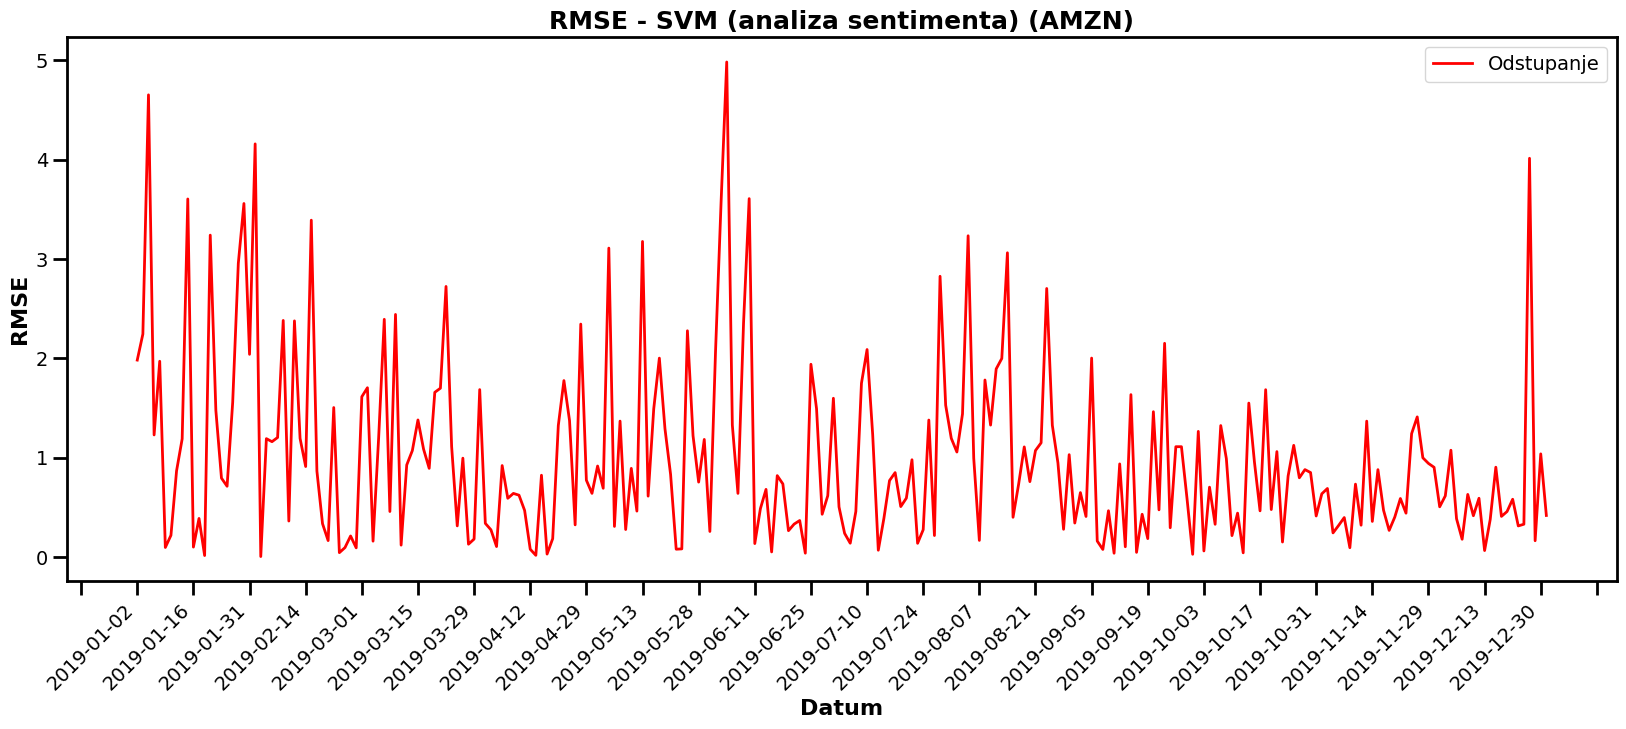

In [9]:
plot_data = data.copy()
plot_data = plot_data.iloc[train_size:]

plt.figure(figsize=(20, 8))
plt.plot(plot_data["Date"], rmse_values, label='Odstupanje', color='red', linewidth=2)  # Increase line width

# Set major ticks interval for x-axis and rotate date labels
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))
plt.gcf().autofmt_xdate(rotation=45)

# Increase the thickness of the axis and tick marks
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.tick_params(axis='both', which='major', labelsize=14, width=2, length=10)
plt.tick_params(axis='both', which='minor', labelsize=12, width=1.5, length=5)

# Set font properties for xlabel, ylabel, and title
plt.xlabel('Datum', fontsize=16, fontweight='bold')
plt.ylabel('RMSE', fontsize=16, fontweight='bold')
plt.title('RMSE - SVM (analiza sentimenta) (AMZN)', fontsize=18, fontweight='bold')

# Customize the legend to make the label "Odstupanje" fatter
plt.legend(fontsize=14, loc='best', frameon=True)

plt.show()


In [10]:
excel = {
    'Date': plot_data["Date"],
    'RMSE': rmse_values
}
df = pd.DataFrame(excel)

# Export to an Excel file
excel_file_path = 'SVM_tweet_GOOG_rmse_values.xlsx'
df.to_excel(excel_file_path, index=False)

mse = mean_squared_error(actual_values, predicted_values)
rmse = np.sqrt(mse)
print(rmse)

1.3618353961904863


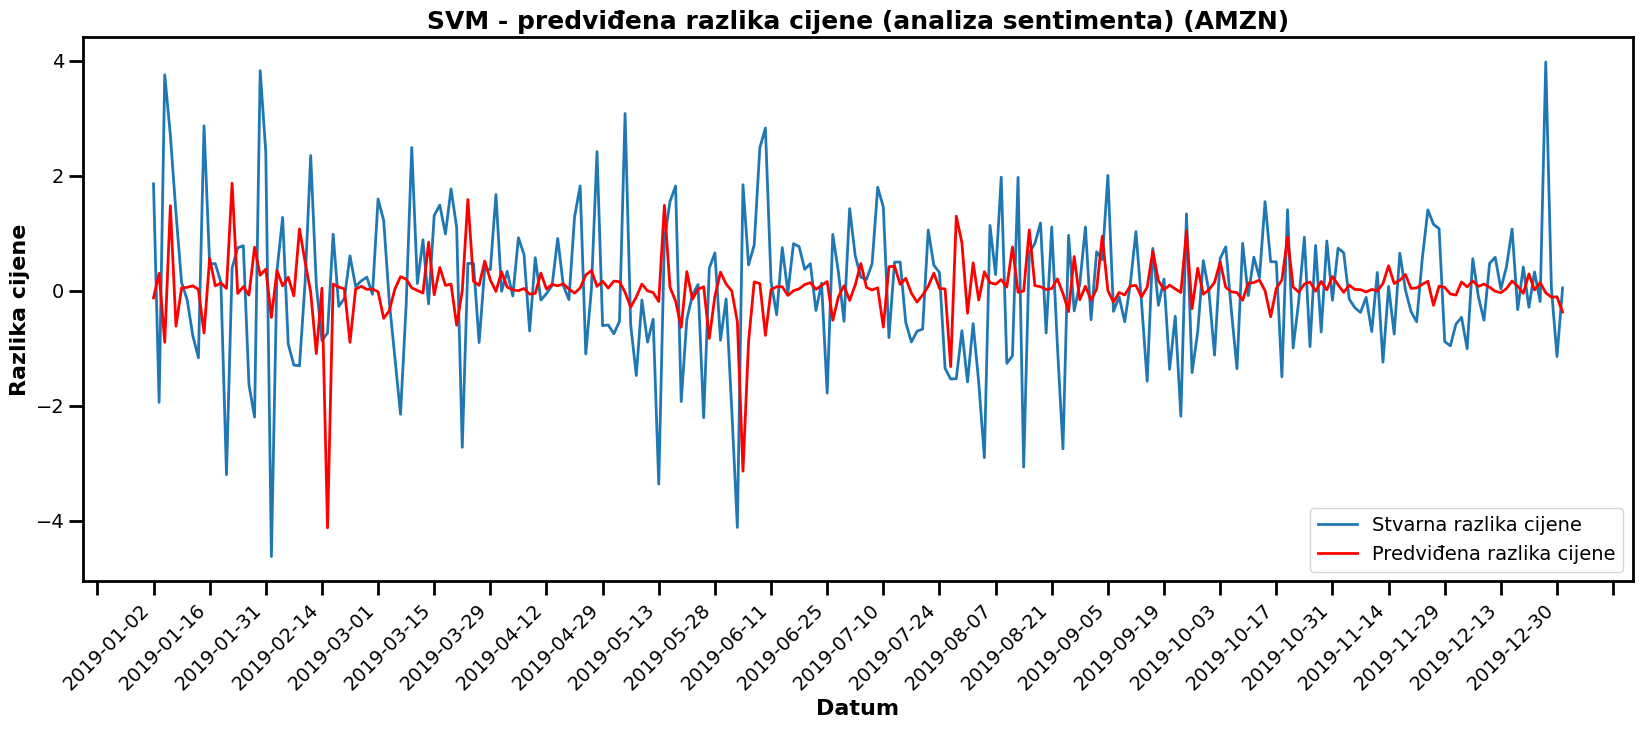

In [11]:
plot_data = data.copy()
plot_data = plot_data.iloc[train_size:]

plt.figure(figsize=(20, 8))

# Plot the actual and predicted values with increased line width
plt.plot(plot_data["Date"], actual_values, label='Stvarna razlika cijene', linewidth=2)  # Thicker line
plt.plot(plot_data["Date"], predicted_values, label='Predviđena razlika cijene', color='red', linewidth=2)  # Thicker line

# Set major ticks interval for x-axis and rotate date labels
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))
plt.gcf().autofmt_xdate(rotation=45)

# Increase the thickness of the axis and tick marks
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.tick_params(axis='both', which='major', labelsize=14, width=2, length=10)
plt.tick_params(axis='both', which='minor', labelsize=12, width=1.5, length=5)

# Set font properties for xlabel, ylabel, and title
plt.xlabel('Datum', fontsize=16, fontweight='bold')
plt.ylabel('Razlika cijene', fontsize=16, fontweight='bold')
plt.title('SVM - predviđena razlika cijene (analiza sentimenta) (AMZN)', fontsize=18, fontweight='bold')

# Customize the legend to make the labels fatter and more prominent
plt.legend(fontsize=14, loc='best', frameon=True)

plt.show()


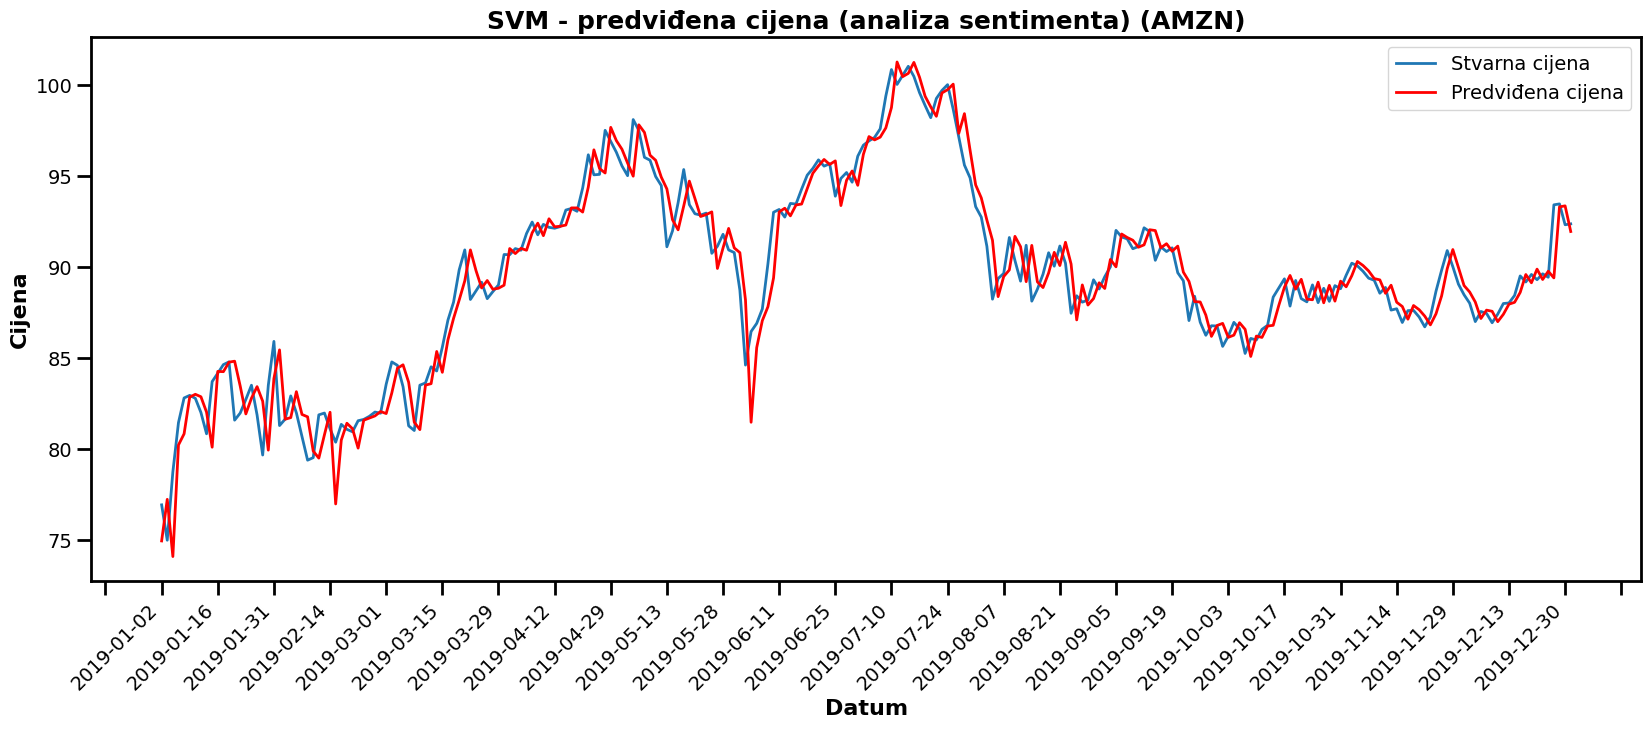

In [12]:
plot_data = data.copy()
plot_data = plot_data.iloc[train_size:]

plot_data["predicted_diff"] = predicted_values
plot_data["Predicted_price"] = plot_data["Adj_Close"] + plot_data["predicted_diff"]

plt.figure(figsize=(20, 8))

# Plot actual and predicted prices with increased line thickness
plt.plot(plot_data["Date"], plot_data["today_price"], label='Stvarna cijena', linewidth=2)  # Thicker line
plt.plot(plot_data["Date"], plot_data["Predicted_price"], label='Predviđena cijena', color='red', linewidth=2)  # Thicker line

# Set major ticks interval for x-axis and rotate date labels
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))
plt.gcf().autofmt_xdate(rotation=45)

# Increase the thickness of the axis and tick marks
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.tick_params(axis='both', which='major', labelsize=14, width=2, length=10)
plt.tick_params(axis='both', which='minor', labelsize=12, width=1.5, length=5)

# Set font properties for xlabel, ylabel, and title
plt.xlabel('Datum', fontsize=16, fontweight='bold')
plt.ylabel('Cijena', fontsize=16, fontweight='bold')
plt.title('SVM - predviđena cijena (analiza sentimenta) (AMZN)', fontsize=18, fontweight='bold')

# Customize the legend to make the labels fatter and more prominent
plt.legend(fontsize=14, loc='best', frameon=True)

# Calculate and print MSE and RMSE
mse = mean_squared_error(actual_values, predicted_values)
rmse = np.sqrt(mse)

plt.show()
